In [1]:
from utils import *

In [2]:
CONST_COLUMNS = [
    "Stellensubart_1",
    "Stellensubart_2",
    "Stellensubart_3",
    "Stellensubart_4",
    *[f"T{i}" for i in range(1, 35)],
    *[f"TD{i:02d}" for i in range(1, 35)],
    "Preis",
    "Beleuchtet",
    "Laenge",
    "Breite",
    "Eigenfläche",
    "PPSVACWert",
    "Qid",
    "GJ",
]

In [3]:
data = pd.read_pickle("data/decade_price_data_combined_01_09.pkl")

In [4]:
distance_2018 = pd.read_csv(
    "./data/distances/distances_2018_new_algo_200.csv"
).set_index("Qid_1")
distance_2019 = pd.read_csv(
    "./data/distances/distances_2019_new_algo_200.csv"
).set_index("Qid_1")
distance_2020 = pd.read_csv(
    "./data/distances/distances_2020_new_algo_200.csv"
).set_index("Qid_1")
distance_2021 = pd.read_csv(
    "./data/distances/distances_2021_new_algo_200.csv"
).set_index("Qid_1")
distance_2022 = pd.read_csv(
    "./data/distances/distances_2022_new_algo_200.csv"
).set_index("Qid_1")

In [5]:
cleaned_data = data.sort_values(by=["Qid", "GJ"]).set_index("Qid", drop=False)
cleaned_data = cleaned_data.loc[:, CONST_COLUMNS]

# Normalize cols

In [6]:
list_of_t = [f"TD{i:02d}" for i in range(1, 35)]

for i in list_of_t:
    cleaned_data[i] = (
        cleaned_data[i] - cleaned_data[i].mean()
    ) / cleaned_data[i].std()

cleaned_data.Preis = (
    cleaned_data.Preis - cleaned_data.Preis.mean()
) / cleaned_data.Preis.std()
cleaned_data.Laenge = (
    cleaned_data.Laenge - cleaned_data.Laenge.mean()
) / cleaned_data.Laenge.std()
cleaned_data.Breite = (
    cleaned_data.Breite - cleaned_data.Breite.mean()
) / cleaned_data.Breite.std()
cleaned_data.PPSVACWert = (
    cleaned_data.PPSVACWert - cleaned_data.PPSVACWert.mean()
) / cleaned_data.PPSVACWert.std()

In [7]:
data_2018 = cleaned_data[cleaned_data.GJ == 2018].drop(columns=["Qid", "GJ"]).copy()
data_2019 = cleaned_data[cleaned_data.GJ == 2019].drop(columns=["Qid", "GJ"]).copy()
data_2020 = cleaned_data[cleaned_data.GJ == 2020].drop(columns=["Qid", "GJ"]).copy()
data_2021 = cleaned_data[cleaned_data.GJ == 2021].drop(columns=["Qid", "GJ"]).copy()
data_2022 = cleaned_data[cleaned_data.GJ == 2022].drop(columns=["Qid", "GJ"]).copy()
data_2023 = cleaned_data[cleaned_data.GJ == 2023].drop(columns=["Qid", "GJ"]).copy()

In [8]:
data_2023.loc[:, "T1":"T22"] = data_2023.loc[:, "T1":"T22"].replace(-1, 0)

In [9]:
all_valid_qids = cleaned_data[cleaned_data.Eigenfläche == 1].Qid.unique()

In [10]:
qid_train, qid_val = train_test_split(all_valid_qids, test_size=0.05, random_state=666)

# Data Loading

In [11]:
def DataPreprocessor(qids):
    
    MAX_NEIGH = 10
    
    columns_to_drop = [
        "PPSVACWert",
        *[f"T{i}" for i in range(1, 35)],
        *[f"TD{i:02d}" for i in range(1, 35)],
    ]

    global data_2018, data_2019, data_2020, data_2021, data_2022, data_2023
    global distance_2018, distance_2019, distance_2020, distance_2021, distance_2022
    X, x, y = [], [], []

    all_year_data = [data_2018, data_2019, data_2020, data_2021, data_2022]
    all_year_distances = [
        distance_2018,
        distance_2019,
        distance_2020,
        distance_2021,
        distance_2022,
    ]

    for idx, qid in enumerate(tqdm(qids)):
        
        if (data_2023.index == qid).sum():

            neighbours_features = []

            for year_data, year_distances in zip(all_year_data, all_year_distances):
                current_distances = year_distances[year_distances.index == qid]

                if (current_distances.shape[0] != 0) and ((year_data.index == qid).sum() != 0):
                    current_year_neighbours = current_distances[
                        current_distances.Qid_2 != qid
                    ]
#                     current_year_neighbours_data = torch.from_numpy(
#                         year_data.loc[current_year_neighbours.Qid_2].values
#                     )
                    
                    current_year_neighbours_data = torch.from_numpy(
                        year_data[year_data.index.isin(current_year_neighbours.Qid_2)].values
                    )
                    current_year_neighbours_data_padded = pad(
                        current_year_neighbours_data,
                        (0, 0, 0, MAX_NEIGH - current_year_neighbours_data.shape[0]),
                        "constant",
                        0,
                    )

                    current_year_self_data = torch.from_numpy(year_data.loc[qid].values)

                    if (current_year_self_data.ndim == 2) and (
                        current_year_self_data.shape[0] > 1
                    ):
                        current_year_self_data = current_year_self_data[0]

                    current_year_data_point = torch.cat(
                        [current_year_self_data[None], current_year_neighbours_data_padded],
                        dim=0,
                    )

                else:
                    # Fill with dummy zeros
                    current_year_data_point = torch.zeros(11, 78)

                neighbours_features.append(current_year_data_point)


            self_data_2023 = torch.from_numpy(
                data_2023.loc[qid].drop(labels=columns_to_drop).values
            )

            neighbours_features = torch.stack(neighbours_features, dim=0)
            label = torch.tensor(data_2023.loc[qid, "T1":"T22"].mean())

            X.append(neighbours_features)
            x.append(self_data_2023)
            y.append(label)

    X = torch.stack(X, dim=0)
    x = torch.stack(x, dim=0)
    y = torch.stack(y, dim=0)

    return X, x, y

In [12]:
X_train, x_train, y_train = DataPreprocessor(qid_train)

100%|██████████████████████████████████████████████████████████████| 63586/63586 [11:53<00:00, 89.15it/s]


In [13]:
torch.save(X_train, "./data/X_train_lstm_decade_price_08_09.pt")
torch.save(x_train, "./data/x_train_lstm_decade_price_08_09.pt")
torch.save(y_train, "./data/y_train_lstm_decade_price_08_09.pt")

In [14]:
X_val, x_val, y_val = DataPreprocessor(qid_val)

100%|████████████████████████████████████████████████████████████████| 3347/3347 [00:38<00:00, 87.31it/s]


In [15]:
torch.save(X_val, "./data/X_val_lstm_decade_price_08_09.pt")
torch.save(x_val, "./data/x_val_lstm_decade_price_08_09.pt")
torch.save(y_val, "./data/y_val_lstm_decade_price_08_09.pt")

In [50]:
# test_qids = [9333.,   9339.,   9340.,   9350.,   9352.,   9394.,   9400.,
#              9404.,   9405.,   9502.,   9503.,   9525.,   9526.,   9641.,
#              9642.,   9815.,   9816.,   9817.,   9818.,   9846.,   9847.,
#              9858.,   9859.,   9932.,   9933., 785704., 931305., 931326.,
#              9855.,   9948.,  20457.,  20472.,  20594.,  20595.,  20643.,
#              20775.,  20917.,  20918.,  20919.,  20941.,  24605.,  26395.,
#              26396., 327508., 327509., 344212., 814900., 840435., 842866.,
#              887322., 931310., 931324.,   9860.,   9672.,   9673.,   9674.]

# test_qids.sort()
test_qids = np.array([9860, 9673, 9855, 9333])

In [1]:
# # loading test data
X_test, x_test, y_test = DataPreprocessor(test_qids)

torch.save(X_test, "./data/X_test_lstm_decade_price_07_09.pt")
torch.save(x_test, "./data/x_test_lstm_decade_price_07_09.pt")
torch.save(y_test, "./data/y_test_lstm_decade_price_07_09.pt")

NameError: name 'DataPreprocessor' is not defined

# Models

In [2]:
from utils import *

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )

        self.fc_1 = nn.Sequential(
            nn.Linear(11, 1),
        )

        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size // 1, hidden_size // 2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 8, output_size),
        )

        self.fc_b = nn.Linear(input_size - 69, input_size)

    def forward(self, x, x_2023):
        out = self.fc_1(x)
        out = out[..., 0]

        x_2023 = self.fc_b(x_2023)[:, None, ...]
        out = torch.cat([out, x_2023], dim=1)

        out, _ = self.lstm(out)
        out = out[:, -1, ...]

        out = self.fc_2(out)
        
        return out

In [32]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_X, path_x, path_y, p=0.1, smooth_labels=False):
        
        self.data_X = torch.load(path_X)
        self.data_X = self.data_X.permute(0, 1, 3, 2)
        self.data_x = torch.load(path_x)
        self.data_y = torch.load(path_y)

        self.p = p

    def __getitem__(self, index):
        if torch.rand(1) < self.p:
            return self.__transform(
                self.data_X[index].clone(),
                self.data_x[index].clone(),
                self.data_y[index].clone(),
            )
        else:
            return (
                self.data_X[index],
                self.data_x[index],
                self.data_y[index]
            )

    def __len__(self):
        return len(self.data_X)

    def __transform(self, item_X, item_x, item_y, k=2):
        max_price = max(item_X[:, -6, 0])
        item_x[-5] = k * max_price
        item_y = item_y * 0

        N = item_X.shape[-1] - 1
        neighbours_features = item_X[:, :, 1:][:, :, torch.randperm(N)]
        self_features = item_X[:, :, 0][:, :, None]
        
        item_X = torch.cat([self_features, neighbours_features], dim=-1)

        return item_X, item_x, item_y

# Defining hyperparametrs

In [5]:
BATCH_SIZE = 64
LEARNING_RATE = 0.00003

In [6]:
model = LSTMModel(78, 512, 5, 1).to(DEVICE)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, LEARNING_RATE, LEARNING_RATE*10, mode="exp_range", cycle_momentum=False)

In [33]:
train_dataset = CustomDataset(
    "./data/X_train_lstm_decade_price_08_09.pt",
    "./data/x_train_lstm_decade_price_08_09.pt",
    "./data/y_train_lstm_decade_price_08_09.pt",
    p=1.
)

val_dataset = CustomDataset(
    "./data/X_val_lstm_decade_price_08_09.pt",
    "./data/x_val_lstm_decade_price_08_09.pt",
    "./data/y_val_lstm_decade_price_08_09.pt",
)

In [7]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)

In [8]:
num_epochs = 200
history = []
val_min_loss = None
model_name = input("Input proper model name:\t")

for epoch in range(num_epochs):
    train_running_loss = 0.0
    model.train()

    for batch in tqdm(train_dataloader, position=0, leave=True):
        # Every data instance is an input + label pair
        X_train1 = batch[0].to(torch.float32).to(DEVICE)
        x_train1 = batch[1].to(torch.float32).to(DEVICE)
        y_train1 = batch[2].to(torch.float32).to(DEVICE)
        outputs = model(X_train1, x_train1)
        loss = criterion(outputs, y_train1.view(-1, 1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        train_running_loss += loss.item()

    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, position=0, leave=True):
            # Every data instance is an input + label pair
            X_val1 = batch[0].to(torch.float32).to(DEVICE)
            x_val1 = batch[1].to(torch.float32).to(DEVICE)
            y_val1 = batch[2].to(torch.float32).to(DEVICE)
            outputs = model(X_val1, x_val1)
            loss = criterion(outputs, y_val1.view(-1, 1))
            val_running_loss += loss.item()

    mean_train_loss = train_running_loss / len(train_dataloader)
    mean_val_loss = val_running_loss / len(val_dataloader)

    # scheduler.step(mean_val_loss)

    if val_min_loss is None:
        val_min_loss = mean_val_loss
    elif mean_val_loss < val_min_loss:
        val_min_loss = mean_val_loss
        torch.save(model.state_dict(), f"./models/{model_name}.pth")

    history.append([mean_train_loss, mean_val_loss])
    print(
        f"Epoch [{epoch+1}/{num_epochs}]\nTrain Loss: {round(mean_train_loss, 4)}\nVal Loss: {round(mean_val_loss, 4)}"
    )

Input proper model name:	test_088


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 286.13it/s]


Epoch [1/200]
Train Loss: 0.207
Val Loss: 0.1675


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 355.58it/s]


Epoch [2/200]
Train Loss: 0.1562
Val Loss: 0.1438


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 356.37it/s]


Epoch [3/200]
Train Loss: 0.1395
Val Loss: 0.1316


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 276.00it/s]


Epoch [4/200]
Train Loss: 0.1278
Val Loss: 0.1238


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 284.14it/s]


Epoch [5/200]
Train Loss: 0.1198
Val Loss: 0.1202


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 347.91it/s]


Epoch [6/200]
Train Loss: 0.1173
Val Loss: 0.1198


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 350.60it/s]


Epoch [7/200]
Train Loss: 0.1125
Val Loss: 0.1083


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 348.15it/s]


Epoch [8/200]
Train Loss: 0.1053
Val Loss: 0.101


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 345.75it/s]


Epoch [9/200]
Train Loss: 0.0993
Val Loss: 0.0985


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 342.00it/s]


Epoch [10/200]
Train Loss: 0.0947
Val Loss: 0.0971


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 336.95it/s]


Epoch [11/200]
Train Loss: 0.0962
Val Loss: 0.0991


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 281.99it/s]


Epoch [12/200]
Train Loss: 0.0981
Val Loss: 0.0987


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 279.45it/s]


Epoch [13/200]
Train Loss: 0.0966
Val Loss: 0.1044


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 349.73it/s]


Epoch [14/200]
Train Loss: 0.0934
Val Loss: 0.09


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 338.47it/s]


Epoch [15/200]
Train Loss: 0.0911
Val Loss: 0.0955


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 359.13it/s]


Epoch [16/200]
Train Loss: 0.0926
Val Loss: 0.095


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 350.08it/s]


Epoch [17/200]
Train Loss: 0.0952
Val Loss: 0.093


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 347.43it/s]


Epoch [18/200]
Train Loss: 0.0927
Val Loss: 0.0924


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 345.01it/s]


Epoch [19/200]
Train Loss: 0.0897
Val Loss: 0.0888


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 273.33it/s]


Epoch [20/200]
Train Loss: 0.0888
Val Loss: 0.0887


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 345.59it/s]


Epoch [21/200]
Train Loss: 0.0911
Val Loss: 0.1015


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 240.69it/s]


Epoch [22/200]
Train Loss: 0.0931
Val Loss: 0.0892


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 339.18it/s]


Epoch [23/200]
Train Loss: 0.09
Val Loss: 0.0866


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 343.42it/s]


Epoch [24/200]
Train Loss: 0.0862
Val Loss: 0.0865


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 276.72it/s]


Epoch [25/200]
Train Loss: 0.087
Val Loss: 0.0885


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 349.08it/s]


Epoch [26/200]
Train Loss: 0.0888
Val Loss: 0.0959


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 275.59it/s]


Epoch [27/200]
Train Loss: 0.09
Val Loss: 0.0873


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 345.72it/s]


Epoch [28/200]
Train Loss: 0.0869
Val Loss: 0.0853


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 313.35it/s]


Epoch [29/200]
Train Loss: 0.0844
Val Loss: 0.0867


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 327.11it/s]


Epoch [30/200]
Train Loss: 0.0855
Val Loss: 0.089


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 279.03it/s]


Epoch [31/200]
Train Loss: 0.0875
Val Loss: 0.0887


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 351.19it/s]


Epoch [32/200]
Train Loss: 0.0874
Val Loss: 0.0943


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 353.46it/s]


Epoch [33/200]
Train Loss: 0.0851
Val Loss: 0.0851


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 333.16it/s]


Epoch [34/200]
Train Loss: 0.0832
Val Loss: 0.0874


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 281.28it/s]


Epoch [35/200]
Train Loss: 0.0847
Val Loss: 0.0929


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 349.25it/s]


Epoch [36/200]
Train Loss: 0.0859
Val Loss: 0.091


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 277.43it/s]


Epoch [37/200]
Train Loss: 0.0857
Val Loss: 0.0884


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 276.82it/s]


Epoch [38/200]
Train Loss: 0.083
Val Loss: 0.0849


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 348.52it/s]


Epoch [39/200]
Train Loss: 0.0816
Val Loss: 0.0853


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 354.20it/s]


Epoch [40/200]
Train Loss: 0.0839
Val Loss: 0.0898


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 279.91it/s]


Epoch [41/200]
Train Loss: 0.0853
Val Loss: 0.087


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 285.00it/s]


Epoch [42/200]
Train Loss: 0.0838
Val Loss: 0.0845


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 356.64it/s]


Epoch [43/200]
Train Loss: 0.081
Val Loss: 0.0844


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 289.42it/s]


Epoch [44/200]
Train Loss: 0.0815
Val Loss: 0.0851


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 285.90it/s]


Epoch [45/200]
Train Loss: 0.0834
Val Loss: 0.0877


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 329.71it/s]


Epoch [46/200]
Train Loss: 0.0842
Val Loss: 0.0858


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 278.90it/s]


Epoch [47/200]
Train Loss: 0.082
Val Loss: 0.084


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 344.08it/s]


Epoch [48/200]
Train Loss: 0.0798
Val Loss: 0.0844


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 350.06it/s]


Epoch [49/200]
Train Loss: 0.0805
Val Loss: 0.0875


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 280.85it/s]


Epoch [50/200]
Train Loss: 0.0827
Val Loss: 0.0868


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 340.57it/s]


Epoch [51/200]
Train Loss: 0.0828
Val Loss: 0.0812


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 279.37it/s]


Epoch [52/200]
Train Loss: 0.0802
Val Loss: 0.0841


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 348.56it/s]


Epoch [53/200]
Train Loss: 0.0782
Val Loss: 0.081


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 280.44it/s]


Epoch [54/200]
Train Loss: 0.0794
Val Loss: 0.0875


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 282.75it/s]


Epoch [55/200]
Train Loss: 0.0819
Val Loss: 0.0837


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 284.08it/s]


Epoch [56/200]
Train Loss: 0.0815
Val Loss: 0.0858


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 359.28it/s]


Epoch [57/200]
Train Loss: 0.0785
Val Loss: 0.0863


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 354.85it/s]


Epoch [58/200]
Train Loss: 0.0767
Val Loss: 0.0819


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 279.93it/s]


Epoch [59/200]
Train Loss: 0.0788
Val Loss: 0.0845


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 280.77it/s]


Epoch [60/200]
Train Loss: 0.0801
Val Loss: 0.0889


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 352.73it/s]


Epoch [61/200]
Train Loss: 0.0796
Val Loss: 0.0842


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 349.64it/s]


Epoch [62/200]
Train Loss: 0.0769
Val Loss: 0.0842


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 275.90it/s]


Epoch [63/200]
Train Loss: 0.076
Val Loss: 0.0855


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 350.88it/s]


Epoch [64/200]
Train Loss: 0.0778
Val Loss: 0.0861


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 276.58it/s]


Epoch [65/200]
Train Loss: 0.0794
Val Loss: 0.0867


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 274.55it/s]


Epoch [66/200]
Train Loss: 0.0771
Val Loss: 0.0846


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 270.85it/s]


Epoch [67/200]
Train Loss: 0.074
Val Loss: 0.0844


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 276.16it/s]


Epoch [68/200]
Train Loss: 0.0746
Val Loss: 0.0859


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 283.02it/s]


Epoch [69/200]
Train Loss: 0.0769
Val Loss: 0.0859


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 275.74it/s]


Epoch [70/200]
Train Loss: 0.0772
Val Loss: 0.0836


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 346.39it/s]


Epoch [71/200]
Train Loss: 0.0752
Val Loss: 0.0875


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 274.01it/s]


Epoch [72/200]
Train Loss: 0.0726
Val Loss: 0.0861


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 332.95it/s]


Epoch [73/200]
Train Loss: 0.0734
Val Loss: 0.0856


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 280.31it/s]


Epoch [74/200]
Train Loss: 0.0754
Val Loss: 0.0848


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 354.67it/s]


Epoch [75/200]
Train Loss: 0.076
Val Loss: 0.0862


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 324.80it/s]


Epoch [76/200]
Train Loss: 0.0726
Val Loss: 0.0828


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 280.47it/s]


Epoch [77/200]
Train Loss: 0.0704
Val Loss: 0.0851


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 351.08it/s]


Epoch [78/200]
Train Loss: 0.0724
Val Loss: 0.0866


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 278.53it/s]


Epoch [79/200]
Train Loss: 0.0749
Val Loss: 0.086


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 285.13it/s]


Epoch [80/200]
Train Loss: 0.0733
Val Loss: 0.0863


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 278.76it/s]


Epoch [81/200]
Train Loss: 0.0698
Val Loss: 0.0878


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 274.99it/s]


Epoch [82/200]
Train Loss: 0.0686
Val Loss: 0.0833


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 347.32it/s]


Epoch [83/200]
Train Loss: 0.0707
Val Loss: 0.0874


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 282.52it/s]


Epoch [84/200]
Train Loss: 0.0732
Val Loss: 0.0867


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 349.19it/s]


Epoch [85/200]
Train Loss: 0.0706
Val Loss: 0.0853


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 346.26it/s]


Epoch [86/200]
Train Loss: 0.067
Val Loss: 0.085


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 275.85it/s]


Epoch [87/200]
Train Loss: 0.067
Val Loss: 0.0876


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 347.98it/s]


Epoch [88/200]
Train Loss: 0.0703
Val Loss: 0.088


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 349.03it/s]


Epoch [89/200]
Train Loss: 0.0715
Val Loss: 0.0917


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 341.34it/s]


Epoch [90/200]
Train Loss: 0.0678
Val Loss: 0.085


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 281.01it/s]


Epoch [91/200]
Train Loss: 0.0643
Val Loss: 0.0873


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 279.77it/s]


Epoch [92/200]
Train Loss: 0.0653
Val Loss: 0.0867


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 273.87it/s]


Epoch [93/200]
Train Loss: 0.0686
Val Loss: 0.087


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 284.14it/s]


Epoch [94/200]
Train Loss: 0.069
Val Loss: 0.0876


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 277.30it/s]


Epoch [95/200]
Train Loss: 0.0648
Val Loss: 0.0858


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 224.25it/s]


Epoch [96/200]
Train Loss: 0.0619
Val Loss: 0.0876


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 275.39it/s]


Epoch [97/200]
Train Loss: 0.0642
Val Loss: 0.086


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 272.85it/s]


Epoch [98/200]
Train Loss: 0.0669
Val Loss: 0.088


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 329.21it/s]


Epoch [99/200]
Train Loss: 0.0656
Val Loss: 0.0879


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 285.25it/s]


Epoch [100/200]
Train Loss: 0.0617
Val Loss: 0.0891


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 364.13it/s]


Epoch [101/200]
Train Loss: 0.0592
Val Loss: 0.0895


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 361.43it/s]


Epoch [102/200]
Train Loss: 0.0623
Val Loss: 0.0929


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 273.23it/s]


Epoch [103/200]
Train Loss: 0.0647
Val Loss: 0.0874


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 342.08it/s]


Epoch [104/200]
Train Loss: 0.0622
Val Loss: 0.0874


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 357.99it/s]


Epoch [105/200]
Train Loss: 0.0584
Val Loss: 0.0883


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 359.76it/s]


Epoch [106/200]
Train Loss: 0.057
Val Loss: 0.0873


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 273.56it/s]


Epoch [107/200]
Train Loss: 0.0608
Val Loss: 0.0893


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 275.14it/s]


Epoch [108/200]
Train Loss: 0.0627
Val Loss: 0.0868


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 306.48it/s]


Epoch [109/200]
Train Loss: 0.0586
Val Loss: 0.087


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 347.95it/s]


Epoch [110/200]
Train Loss: 0.0544
Val Loss: 0.0874


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 345.84it/s]


Epoch [111/200]
Train Loss: 0.0552
Val Loss: 0.0894


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 338.39it/s]


Epoch [112/200]
Train Loss: 0.0588
Val Loss: 0.0907


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 281.84it/s]


Epoch [113/200]
Train Loss: 0.0599
Val Loss: 0.0898


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 283.68it/s]


Epoch [114/200]
Train Loss: 0.0551
Val Loss: 0.0889


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 287.57it/s]


Epoch [115/200]
Train Loss: 0.0511
Val Loss: 0.0897


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 274.49it/s]


Epoch [116/200]
Train Loss: 0.0535
Val Loss: 0.0897


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 351.33it/s]


Epoch [117/200]
Train Loss: 0.0573
Val Loss: 0.0901


100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 356.34it/s]


Epoch [118/200]
Train Loss: 0.0562
Val Loss: 0.0902


 19%|████████████▌                                                    | 162/839 [00:01<00:04, 151.12it/s]


KeyboardInterrupt: 

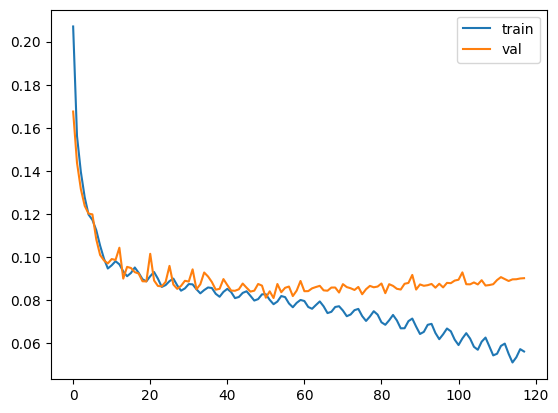

In [9]:
plt.plot(history)
plt.legend(["train", "val"]);

# Evaluation

In [10]:
model.load_state_dict(torch.load(f"./models/{model_name}.pth"))
model.eval()
X_val = val_dataset.data_X
x_val = val_dataset.data_x
y_val = val_dataset.data_y
preds = (
    torch.clamp(
    model(X_val.to(torch.float32).to(DEVICE), x_val.to(torch.float32).to(DEVICE))
    .detach()
    .cpu()
    , min=0, max=1)
    .numpy()
    )
ground_truth = (y_val).numpy()

## MAE

In [11]:
print(np.abs(preds[..., 0] - ground_truth).mean().round(4))

0.0541


## Kernel Density Estimation plot

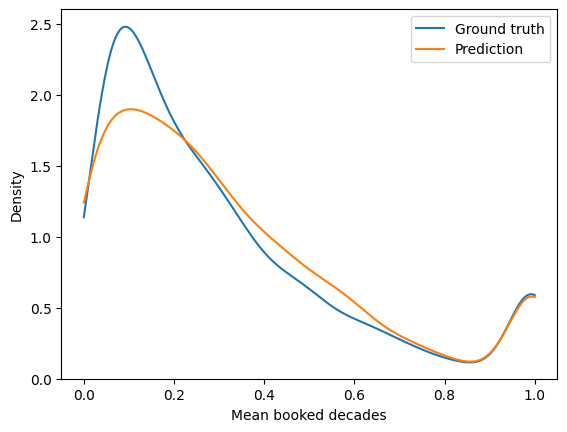

In [12]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    sns.distplot(preds[..., 0],  kde_kws={'clip': (0.0, 1.0)}, hist=False, label='Ground truth')
    sns.distplot(ground_truth,  kde_kws={'clip': (0.0, 1.0)}, hist=False, label='Prediction')
    plt.legend();
    plt.xlabel("Mean booked decades");

## Scatter plot of ground_truth and preds

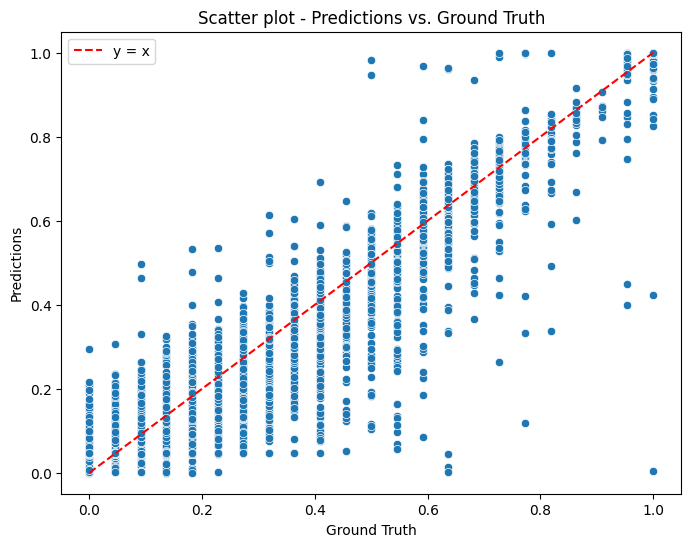

In [13]:
# Create a diagonal line for y = x
x_values = np.linspace(
    min(preds[..., 0].min(), ground_truth.min()),
    max(preds[..., 0].max(), ground_truth.max()),
    100,
)
y_values = x_values

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ground_truth, y=preds[..., 0])

# Plot the diagonal line
plt.plot(x_values, y_values, color="red", linestyle="dashed", label="y = x")

# Set labels and title
plt.xlabel("Ground Truth")

plt.ylabel("Predictions")
plt.title("Scatter plot - Predictions vs. Ground Truth")

# Show the plot
plt.legend()
plt.show()